# treaming Data with Apache Kafka


Apache Kafka ouvre le monde des flux de données en temps réel. Bien qu'il existe des différences fondamentales dans le traitement de flux et le traitement par lots, la façon dont vous créez des pipelines de données sera très similaire. Comprendre les différences entre les données en streaming et le traitement par lots vous permettra de créer des pipelines de données qui tiennent compte de ces différences

## Comprendre les journaux 

Si vous avez écrit du code, vous connaissez peut-être les journaux du logiciel. Les développeurs de logiciels utilisent la journalisation pour écrire la sortie des applications dans un fichier texte pour stocker les différents événements qui se produisent dans le logiciel. Ils utilisent ensuite ces journaux pour aider à déboguer les problèmes qui surviennent. En Python, vous avez probablement implémenté un code similaire au code suivant



    import logginglogging.basicConfig(level=0,filename='python-log.log', filemode='w', format='%(levelname)s - %(message)s')
    logging.debug('Attempted to divide by zero')
    logging.warning('User left field blank in the form')
    logging.error('Couldn't find specified file')



Le code précédent est un exemple de journalisation de base qui consigne différents niveaux - débogage, avertissement et erreur - dans un fichier nommé python-log.log. Le code produira la sortie suivante :


    DEBUG - Attempted to divide by zero
    WARNING - User left field blank in the form
    ERROR - Couldn't find specified file

Les messages sont enregistrés dans le fichier dans l'ordre dans lequel ils apparaissent. Cependant, vous ne connaissez pas l'heure exacte à laquelle l'événement s'est produit. Vous pouvez améliorer ce journal en ajoutant un horodatage, comme indiqué dans le code suivant :


    logging.basicConfig(level=0,filename='python-log.log', filemode='w', format='%(asctime)s - %(levelname)s - %(message)s')
    logging.info('Something happened')
    logging.info('Something else happened, and it was bad')



Les résultats du code précédent sont affichés dans le bloc de code suivant. Notez qu'il y a maintenant un horodatage. Le journal est ordonné, comme l'était le journal précédent. Cependant, l'heure exacte est connue dans ce journal :


2020-06-21 10:55:40,278 - INFO - Something happened
2020-06-21 10:55:40,278 - INFO - Something else happened, and it was bad


Dans les journaux précédents, vous devriez remarquer qu'ils suivent un format ou un schéma très spécifique, qui est défini dans basicConfig. Un autre journal commun que vous connaissez probablement est le journal Web. 

Les journaux du serveur Web sont comme les journaux des logiciels ; ils rapportent des événements - généralement des demandes - dans l'ordre chronologique, avec un horodatage et l'événement. Ces journaux suivent un format très spécique et disposent de nombreux outils pour les analyser. 

Les bases de données utilisent également des journaux en interne pour aider à la réplication et pour enregistrer les modifications dans une transaction. Si les applications, les serveurs Web et les bases de données utilisent tous des journaux et qu'ils sont tous légèrement différents, qu'est-ce qu'un journal exactement ?

 Un journal est une collection ordonnée d'événements, ou d'enregistrements, qui est uniquement ajouté. C'est tout ce qu'il y a à faire. Simple. Jusqu'au point. Et pourtant un outil extrêmement puissant dans le développement de logiciels et le traitement des données. Le diagramme suivant montre un exemple de journal


 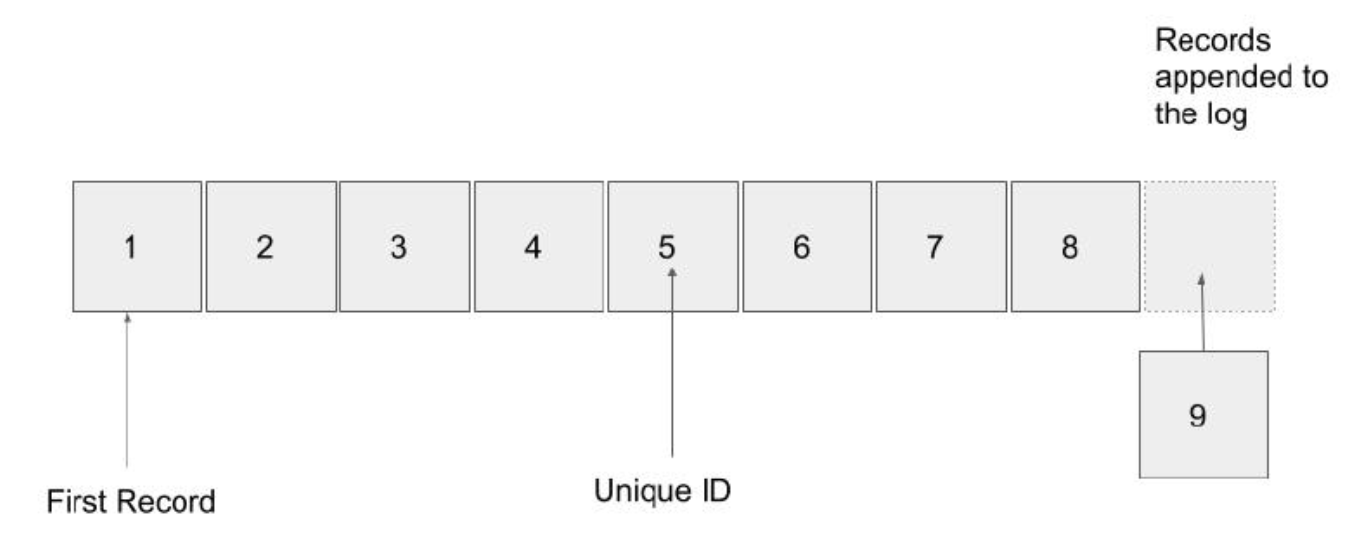

Le diagramme précédent montre les enregistrements individuels sous forme de blocs. Le premier disque est à gauche. Le temps est représenté par la position des enregistrements dans le journal. L'enregistrement à droite d'un autre enregistrement est plus récent. Ainsi, l'enregistrement 3 est plus récent que l'enregistrement 2. Les enregistrements ne sont pas supprimés du journal mais ajoutés à la fin. L'enregistrement 9 est ajouté à l'extrême droite du journal, car il s'agit de l'enregistrement le plus récent - jusqu'à ce que l'enregistrement 10 arrive

## Comprendre comment Kafka utilise les logs 
Kafka maintient des logs qui sont écrits par les producteurs et lus par les consommateurs. Les sections suivantes expliqueront les sujets, les consommateurs et les producteurs.

## Topic

Apache Kafka utilise des journaux pour stocker des données – des enregistrements. Les journaux dans Kafka sont appelés topic. Un topic est comme une table dans une base de données. Dans le chapitre précédent, vous avez testé votre cluster Kafka en créant un topic nommé dataengineering. Le topic est enregistré sur le disque en tant que fichier journal. Les topic peuvent être un seul log, mais ils sont généralement mis à l'échelle horizontalement en partitions. Chaque partition est un fichier log qui peut être stocké sur un autre serveur. Dans une rubrique avec des partitions, la garantie d'ordre des messages ne s'applique plus à la rubrique, mais uniquement à chaque partition. Le schéma suivant montre un topic divisé en trois partitions :


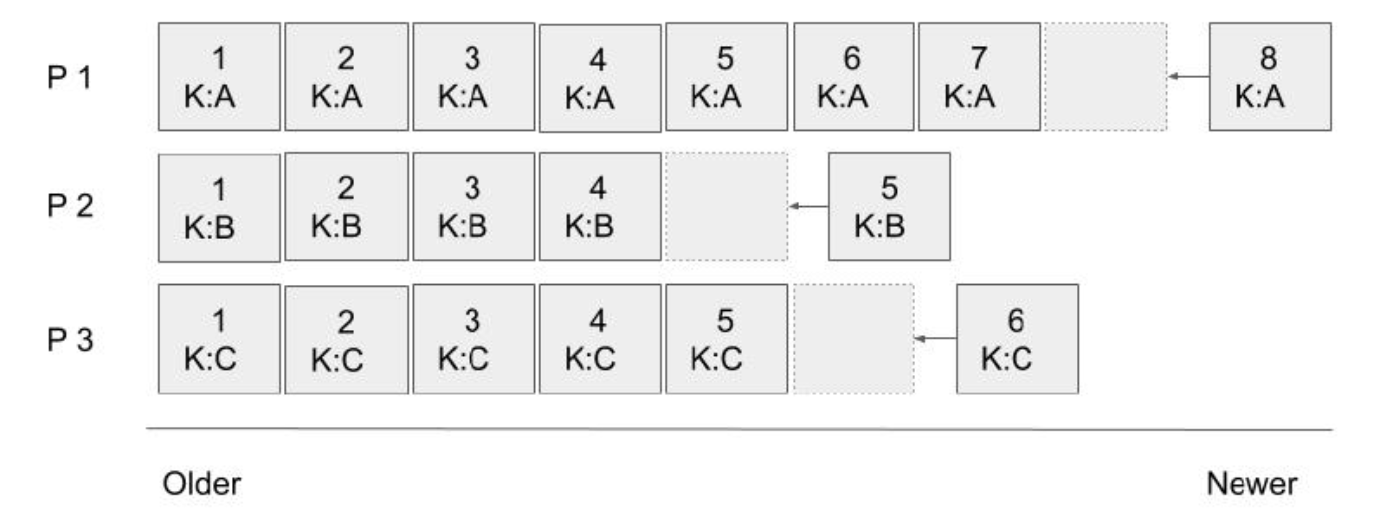

La rubrique précédente – Transactions – comporte trois partitions étiquetées P1, P2 et P3. Dans chaque partition, les enregistrements sont ordonnés, les enregistrements à gauche étant plus anciens que les enregistrements à droite – plus le nombre dans la case est grand, plus l'enregistrement est récent. 

Vous remarquerez que les enregistrements ont K:A dans P1 et K:B et K:C dans P2 et P3, respectivement. Ces dernières sont les clés associées aux enregistrements. En attribuant une clé, vous garantissez que les enregistrements contenant les mêmes clés iront à la même partition. Bien que l'ordre des enregistrements dans le topic puisse être en désordre, chaque partition est en ordre

## Producteurs et consommateurs Kafka

Les producteurs Kafka envoient des données à un topic et à une partition. Les enregistrements peuvent être envoyés en boucle aux partitions ou vous pouvez utiliser une clé pour envoyer des données à des partitions spécifiques. Lorsque vous envoyez des messages avec un producteur, vous pouvez le faire de l'une des trois manières suivantes :


* Fire and Forget : vous envoyez un message et passez à autre chose. Vous n'attendez pas un accusé de réception de Kafka. Dans cette méthode, les enregistrements peuvent être perdus.

* Synchrone : envoyer un message et attendre une réponse avant de continuer.

* Asynchrone : envoyer un message et un rappel. Vous continuez une fois le message envoyé, mais vous obtiendrez une réponse à un moment donné que vous pourrez gérer.



Les producteurs sont assez simples – ils envoient des messages à un topic et à une partition, demandent peut-être un accusé de réception, réessayent si un message échoue – ou non – et continuent. Les consommateurs, cependant, peuvent être un peu plus compliqués.



Les consommateurs lisent les messages d'un sujet. Les consommateurs s'exécutent dans une boucle d'interrogation qui s'exécute indéfiniment en attendant les messages. Les consommateurs peuvent lire depuis le début – ils commenceront par le premier message du sujet et liront l'intégralité de l'historique. Une fois rattrapé, le consommateur attendra de nouveaux messages.


Si un consommateur lit cinq messages, le décalage est cinq. Le décalage est la position du consommateur dans le topic. C'est un signet pour l'endroit où le consommateur se retire. Un consommateur peut toujours commencer à lire un sujet à partir du décalage ou d'un décalage spécifié - qui est stocké par Zookeeper.


Que se passe-t-il lorsque vous avez un consommateur sur le topic d'ingénierie des données, mais que le sujet a trois partitions et écrit des enregistrements plus rapidement que vous ne pouvez le lire ? Le schéma suivant montre un seul consommateur essayant de consommer trois partitions


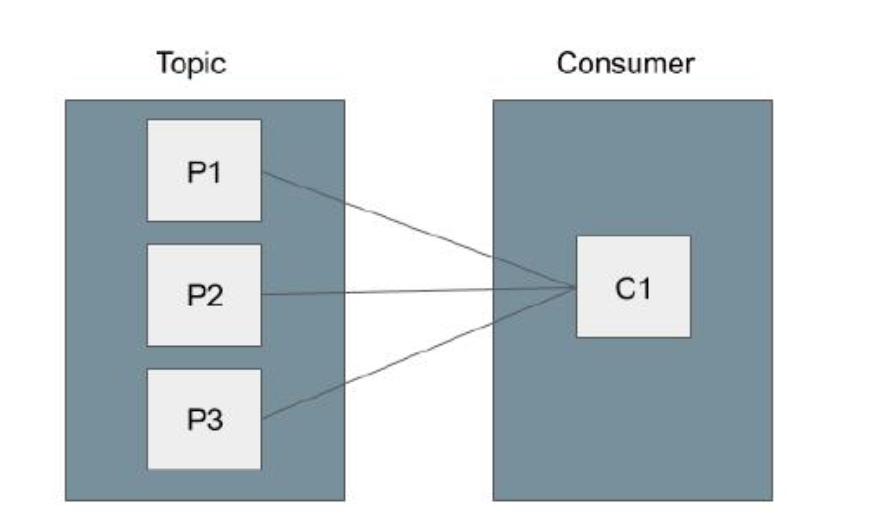

En utilisant des groupes de consommateurs, vous pouvez adapter la lecture des topic Kafka. Dans le schéma précédent, le consommateur C1 fait partie d'un groupe de consommateurs, mais est le seul consommateur. En ajoutant des consommateurs supplémentaires, les topic peuvent être distribués. Le diagramme suivant montre à quoi cela ressemble.

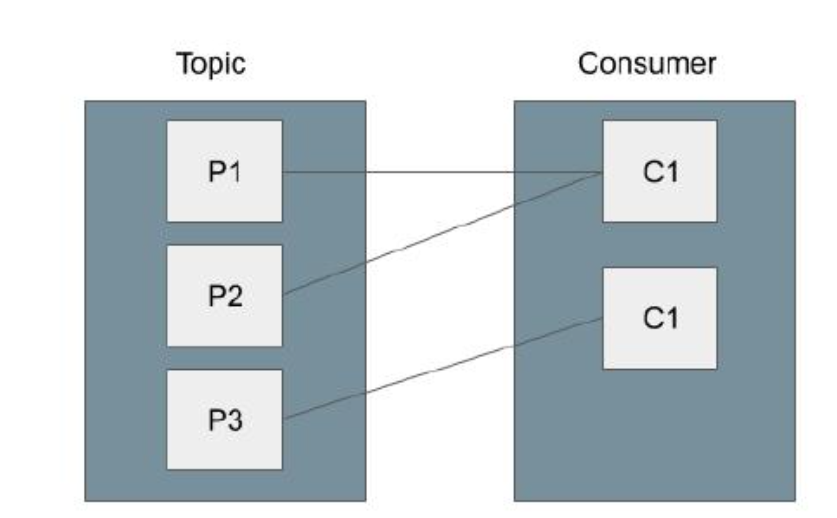

Le schéma précédent montre qu'il y a toujours plus de partitions que de consommateurs dans le groupe, ce qui signifie qu'un consommateur gérera plusieurs partitions. Vous pouvez ajouter d'autres consommateurs, comme illustré dans le schéma suivant :Figure


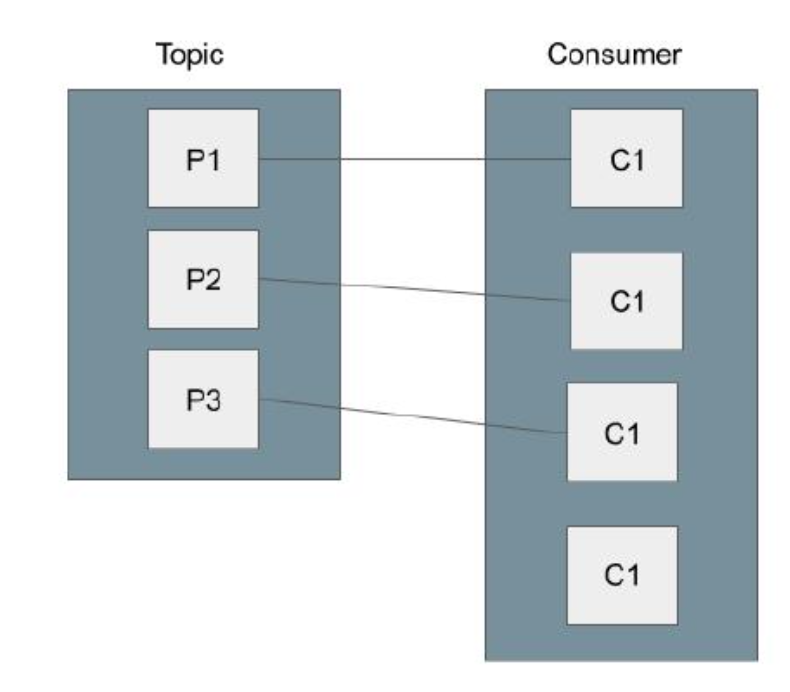

Dans le diagramme précédent, il y a plus de consommateurs dans le groupe de consommateurs que de partitions. Lorsqu'il y a plus de consommateurs que de partitions, les consommateurs restent inactifs. Par conséquent, il n'est pas nécessaire de créer plus de consommateurs que le nombre de partitions. Vous pouvez toutefois créer plusieurs groupes de consommateurs. Le diagramme suivant montre à quoi cela ressemble

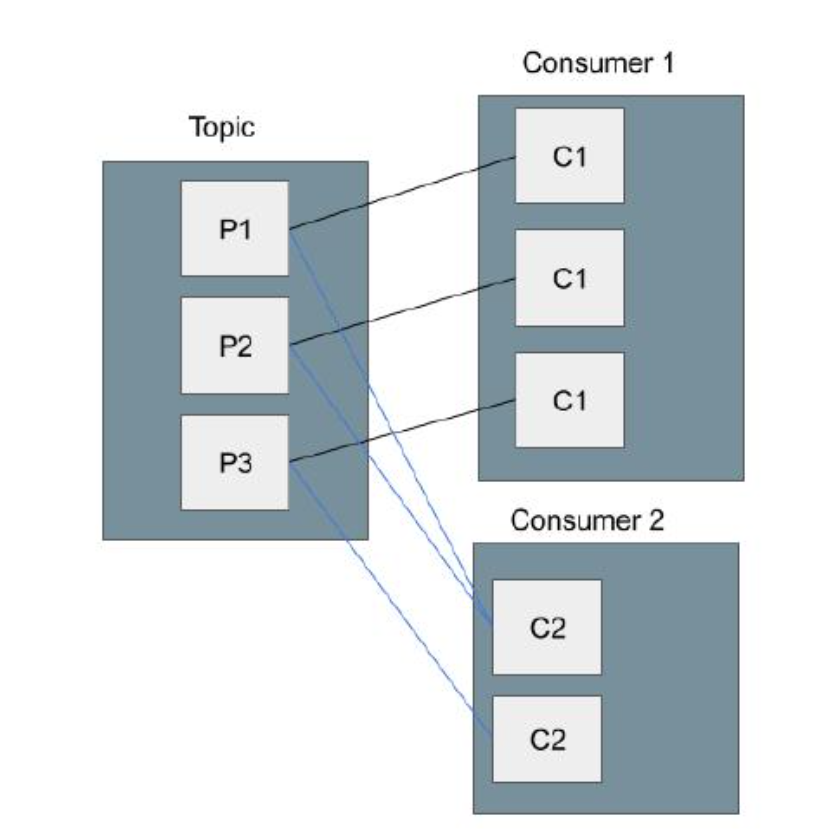

Plusieurs groupes de consommateurs peuvent lire à partir de la même partition. Il est recommandé de créer un groupe de consommateurs pour chaque application qui a besoin d'accéder au sujet. Maintenant que vous comprenez les bases de l'utilisation de Kafka, la section suivante vous montrera comment créer des pipelines de données à l'aide de python et Kafka.

## Différencier le traitement de flux du traitement par lots 

Bien que les outils de traitement ne changent pas si vous traitez des flux ou des lots, il y a deux choses que vous devez garder à l'esprit lors du traitement des flux : illimité et temporel. Les données peuvent être limitées ou illimitées. Les données bornées ont une fin, tandis que les données illimitées sont constamment créées et sont éventuellement infinies. 

Les données bornées correspondent aux ventes de widgets de l'année dernière. Les données illimitées sont un capteur de trafic comptant les voitures et enregistrant leur vitesse sur l'autoroute. Pourquoi est-ce important dans la création de pipelines de données ? 

Parce qu'avec des données bornées, vous saurez tout sur les données. Vous pouvez tout voir à la fois. Vous pouvez l'interroger, le placer dans un environnement intermédiaire, puis exécuter Great Expectations dessus pour avoir une idée des plages, des valeurs ou d'autres métriques à utiliser dans la validation lorsque vous traitez vos données. Avec des données illimitées, elles sont diffusées et vous ne savez pas à quoi ressemblera la prochaine donnée.

 Cela ne signifie pas que vous ne pouvez pas le valider - vous savez que la vitesse d'une voiture doit se situer dans une certaine plage et ne peut pas avoir la valeur h - ce sera un entier compris entre 0 et 200-ish. données, vous pouvez interroger la moyenne ou le maximum d'un champ. Sur les données illimitées, vous devrez continuer à recalculer ces valeurs en tant que flux de données via le pipeline de données. Dans le chapitre suivant, vous découvrirez Apache Spark et comment il peut vous aider à traiter des données illimitées ou en continu. Vous pensez peut-être que oui, les chiffres de vente de l'année dernière sont limités, mais pas ceux de cette année. L'année n'est pas terminée et les données continuent d'affluer. Cela amène la deuxième chose que vous devez garder à l'esprit lorsque vous traitez des flux et c'est le temps. Les données délimitées sont complètes sur une période de temps ou une fenêtre. Et le fenêtrage est une méthode pour rendre les données illimitées limitées

Il existe trois fenêtres courantes – xed, sliding, and session:n : 

* Fixed – Parfois appelées fenêtres à bascule, ces fenêtres couvrent une durée fixe et les enregistrements ne se chevauchent pas. Si vous spécifiez une fenêtre d'une minute, les enregistrements seront compris dans chaque intervalle, comme illustré dans le schéma suivant :

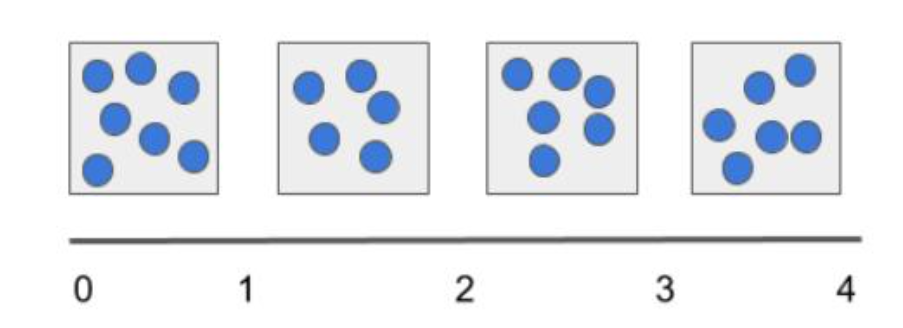

* Sliding  - Il s'agit d'une fenêtre dans laquelle la fenêtre est définie, par exemple 1 minute, mais la fenêtre suivante commence en moins que la longueur de la fenêtre - disons, toutes les 30 secondes. Ce type de fenêtre aura des doublons et est bon pour les moyennes mobiles. Une fenêtre coulissante est illustrée dans le schéma suivant :

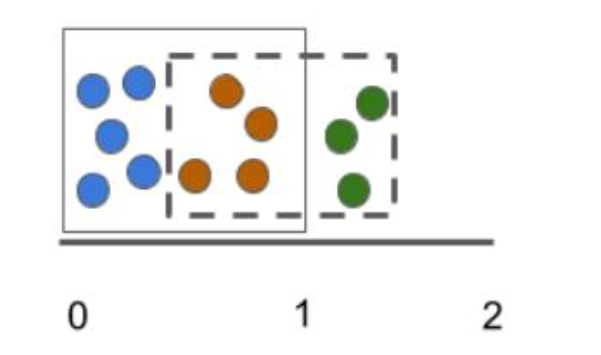

Le schéma montre deux fenêtres, une commençant à 0 qui est prolongée pendant 1 minute. La deuxième fenêtre se chevauche à 0h30 et s'étend sur 1 minute jusqu'à 1h30.


* Session – Les sessions n'auront pas la même fenêtre de temps mais sont des événements. Par exemple, un utilisateur se connecte pour faire des achats, ses données sont diffusées en continu pour cette session de connexion et la session est définie par une partie de données dans les enregistrements, appelée jeton de session.

Lorsque vous discutez des fenêtres et de l'heure, vous devez également prendre en compte l'heure à utiliser : événement, ingestion ou traitement. Les trois heures différentes peuvent avoir des valeurs différentes et celle que vous choisissez dépend de votre cas d'utilisation : 

* Event Time: correspond au moment où l'événement se produit. Cela peut être enregistré dans le dossier avant d'être envoyé à Kafka. Par exemple, à 1:05, une voiture a été enregistrée roulant à 55 mph. 
* Ingest Time: est l'heure à laquelle les données sont enregistrées dans un topic Kafka. La latence entre l'événement et l'enregistrement peut fluctuer en fonction de la latence du réseau. 
* Processing Time est le temps pendant lequel vous lisez les données du topic Kafka et faites quelque chose avec elles - comme les traiter via votre pipeline de données et les mettre dans l'entrepôt


En reconnaissant que vous travaillez peut-être avec des données illimitées, vous éviterez des problèmes dans vos pipelines de données en n'essayant pas d'analyser toutes les données à la fois, mais en choisissant un fenêtrage approprié et en utilisant également le bon moment pour votre cas d'utilisation

## Produire et consommer avec Python

Vous pouvez créer des producteurs et des consommateurs pour Kafkaa à l'aide de Python. Il existe plusieurs bibliothèques Kafka Python – Kafka-Python, PyKafka et Confluent Python Kafka. Dans cette section, j'utiliserai Confluent Python Kafka, mais si vous souhaitez utiliser une bibliothèque open source basée sur la communauté, vous pouvez utiliser Kafka-Python. Les principes et la structure des programmes Python seront les mêmes quelle que soit la bibliothèque que vous choisissez. Pour installer la bibliothèque, vous pouvez utiliser pip. La commande suivante l'installera :


    pip3 install confluent-kafka


Une fois l'installation de la bibliothèque terminée, vous pouvez l'utiliser en l'important dans vos applications. Les sections suivantes vous guideront dans l'écriture d'un producteur et d'un consommateur

## Écrire un producteur Kafka en Python

Pour écrire un producteur en Python, vous allez créer un producteur, envoyer des données et écouter les accusés de réception. Dans les exemples précédents, vous avez utilisé Faker pour créer de fausses données sur les personnes. Vous l'utiliserez à nouveau pour générer les données de cet exemple. Pour écrire le producteur, procédez comme suit :

1. Importez les bibliothèques requises et créez un facke :
    from confluent_kafka import Producer
    from faker import Faker
    import json
    import time

    fake=Faker()

2. Ensuite, créez le producteur en spécifiant les adresses IP de votre cluster Kafka :


    p=Producer({'bootstrap.servers':'localhost:9092,localhost:9093,localhost:9094'})


3. Vous pouvez répertorier les topics disponibles pour publier comme suit :

    #p.list_topics().topics

4. Il existe différents paramètres pour les accusés de réception et la façon dont vous les gérez, mais pour l'instant, créez un rappel qui recevra une erreur (err) et un accusé de réception (msg). Dans chaque appel, un seul d'entre eux sera vrai et aura des données. À l'aide d'une instruction if, vérifiez s'il y a une erreur, sinon, vous pouvez imprimer le message :



    def receipt(err,msg):
        if err is not None:
            print('Error: {}'.format(err))
        else:
            print("{} : Message on topic {} on partition {} with value of {}".format(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(msg.timestamp()[1]/1000)), msg.topic(), msg.partition(), msg.value().decode('utf-8')))


Le code qui imprime le message imprime plusieurs éléments de données dans l'objet message. Le message a un horodatage en millisecondes. Pour le convertir en secondes afin de pouvoir imprimer la date/heure locale, divisez par 1 000. Il imprime ensuite le sujet sur lequel le message a été publié - votre producteur peut écrire sur n'importe quel sujet, donc si vous écrivez sur plusieurs sujets au sein d'un même producteur, vous voudrez savoir quel sujet a fonctionné ou a eu une erreur. Il imprime également la partition (0, 1, 2) puis la valeur du message. Les messages reviennent sous forme d'octets afin que vous puissiez les décoder en utf-8



5. Ensuite, créez la boucle producteur. Le code parcourt une plage créant un faux objet de données. L'objet est le même que dans le chapitre 3, Travailler avec des fichiers. Il vide ensuite le dictionnaire afin qu'il puisse être envoyé à Kafka :



    for i in range(10):
        data={"name":fake.name(),"age":fake.random_int(min=18, max=80, step=1),"street":fake.street_address(),"city":fake.city(),"state":fake.state(),"zip":fake.zipcode()}
        m=json.dumps(data)


6. Avant d'envoyer les données à Kafka, appelez poll() pour obtenir les accusés de réception des messages précédents. Le ose sera envoyé au callback (reçu). Vous pouvez maintenant appeler produire () et transmettre le nom du topic, les données et la fonction à laquelle envoyer les accusés de réception :


        p.poll(0)
        p.produce('users',m.encode('utf-8'),callback=receipt)

7. Pour terminer, rincer le producteur. Cela obtiendra également tous les accusés de réception existants et les enverra à la réception () :


      p.flush()

Les résultats du code précédent seront des messages envoyés au sujet utilisateur sur le cluster Kafka, et le terminal imprimera les accusés de réception, qui ressembleront à la sortie suivante :


    2020-06-22 15:29:30 : Message on topic users on partition 1 with value of
    {'name': 'Willie Chambers', 'age': 66, 'street': '13647 Davis Neck Suite
    480', 'city': 'Richardside', 'state': 'Nebraska', 'zip': '87109'}


Maintenant que vous pouvez envoyer des données à un sujet Kafka, la section suivante vous montrera comment les utiliser.




## Écriture d'un consommateur Kafka en Python

Pour créer un consommateur en Python, vous créez le consommateur pointant vers le cluster Kafka, sélectionnez un sujet à écouter, puis entrez une boucle qui écoute les nouveaux messages. Le code qui suit vous expliquera comment écrire un consommateur Python :


1. Tout d'abord, importez la bibliothèque Consumer et créez le consommateur. Vous passerez les adresses IP de votre cluster Kafka, le nom du groupe de consommateurs - cela peut être tout ce que vous voulez, mais si vous ajoutez plusieurs consommateurs au groupe, ils auront besoin du même nom, et Kafka se souviendra du décalage où ce groupe de consommateurs a cessé de lire le sujet - et enfin, vous passerez la réinitialisation de l'offset, ou l'endroit où vous souhaitez commencer à lire :


    from confluent_kafka import Consumer


    c=Consumer({'bootstrap.servers': 'localhost:9092,localhost:9093,localhost9093','group.id':'python-consumer','auto.offset.reset':'earliest'})



2. Vous pouvez obtenir une liste des sujets auxquels vous pouvez vous abonner ainsi que le nombre de partitions pour un sujet particulier :


    t=c.list_topics()
    t.topics

    #{'people': TopicMetadata(people, 1 partitions), '__transaction_state': TopicMetadata(__transaction_state, 50 partitions), 'users': #TopicMetadata(users, 3 partitions), 'dataengineering': TopicMetadata(dataengineering, 1 partitions), '__consumer_offsets': #TopicMetadata(__consumer_offsets, 50 partitions)}

    t.topics['users'].partitions

    #{0: PartitionMetadata(0), 1: PartitionMetadata(1), 2: PartitionMetadata(2)}

3. Une fois que vous savez quel topic vous souhaitez consommer, vous pouvez vous y abonner :


    c.subscribe(['users'])


4. Pour recevoir des messages, créez une boucle infinie - si vous voulez écouter indéfiniment. Vous pouvez toujours démarrer et arrêter en utilisant le décalage pour reprendre là où vous vous êtes arrêté. Appelez poll() pour obtenir le message. Le résultat sera l'une des trois choses suivantes : rien pour l'instant, une erreur ou un message. À l'aide des instructions if, recherchez un rien, une erreur ou décodez le message et faites quelque chose avec les données, qui dans ce cas est de l'imprimer. Lorsque vous avez terminé, fermez la connexion :




    while True:
        msg=c.poll(1.0) #timeout

        if msg is None:
            continue
      
        if msg.error():
            print("Error: {}".format(msg.error()))
            continue

        data=msg.value().decode('utf-8')
        print(data)
    c.close()

Les résultats seront plusieurs objets JSON défilant dans le terminal et ressembleront à la sortie suivante :


    {'name': 'Joseph Vaughn', 'age': 39, 'street': '978 Jordan Extensions Suite 684', 'city': 'Zunigamouth', 'state': 'Michigan', 'zip': '38090'}



C'est un exemple basique de consommation d'un sujet avec Python, mais devrait vous donner une idée de l'architecture et comment commencer à créer des consommateurs plus complexes

    